In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Coleta de dados

In [2]:
from torchvision.datasets.utils import download_url


# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

Using downloaded and verified file: .\cifar10.tgz
['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Transformação dos dados

In [3]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [4]:
# Carregamos o dataset
train_ds = ImageFolder(data_dir + "/train", train_tfms)
valid_ds = ImageFolder(data_dir + "/test", valid_tfms)

In [5]:
# Definimos o tamanho do batch
batch_size = 400

In [6]:
# Criamos os dataloaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

In [7]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means


def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0, 1))
        break

In [8]:
# show_batch(train_dl)

## Modelagem do classificador

In [9]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

Em relação à CNN desenvolvida no caderno 05, faremos uma mudança chave adicionando uma camada de resíduos.

In [12]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1
        )
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return (
            self.relu2(out) + x
        )  # ReLU can be applied before or after adding the input

In [13]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(
            "Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch,
                result["lrs"][-1],
                result["train_loss"],
                result["val_loss"],
                result["val_acc"],
            )
        )

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    ]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4), nn.Flatten(), nn.Dropout(0.2), nn.Linear(512, num_classes)
        )

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [16]:
# Modelo
model = to_device(ResNet9(3, 10), device)

Antes de treinar, vamos criar um agendamento de taxa de aprendizado, queda do peso e recorte de gradiente

## Treinamento

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_loader,
    val_loader,
    weight_decay=0,
    grad_clip=None,
    opt_func=torch.optim.SGD,
):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3012144565582275, 'val_acc': 0.08701921999454498}]

In [19]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [20]:
history += fit_one_cycle(
    epochs,
    max_lr,
    model,
    train_dl,
    valid_dl,
    grad_clip=grad_clip,
    weight_decay=weight_decay,
    opt_func=opt_func,
)

Epoch [0], last_lr: 0.00393, train_loss: 1.4656, val_loss: 1.1555, val_acc: 0.5994
Epoch [1], last_lr: 0.00935, train_loss: 1.0889, val_loss: 1.2211, val_acc: 0.6250
Epoch [2], last_lr: 0.00972, train_loss: 0.8553, val_loss: 0.8219, val_acc: 0.7263
Epoch [3], last_lr: 0.00812, train_loss: 0.6322, val_loss: 0.6721, val_acc: 0.7777
Epoch [4], last_lr: 0.00556, train_loss: 0.5029, val_loss: 0.7841, val_acc: 0.7461
Epoch [5], last_lr: 0.00283, train_loss: 0.4015, val_loss: 0.3779, val_acc: 0.8727
Epoch [6], last_lr: 0.00077, train_loss: 0.2892, val_loss: 0.3078, val_acc: 0.8933
Epoch [7], last_lr: 0.00000, train_loss: 0.2215, val_loss: 0.2872, val_acc: 0.9036


## Plotagem dos resultados

In [21]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")


def plot_losses(history):
    train_losses = [x.get("train_loss") for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

def plot_lrs(history):
    lrs = np.concatenate([x.get("lrs", []) for x in history])
    plt.plot(lrs)
    plt.xlabel("Batch no.")
    plt.ylabel("Learning rate")
    plt.title("Learning Rate vs. Batch no.")

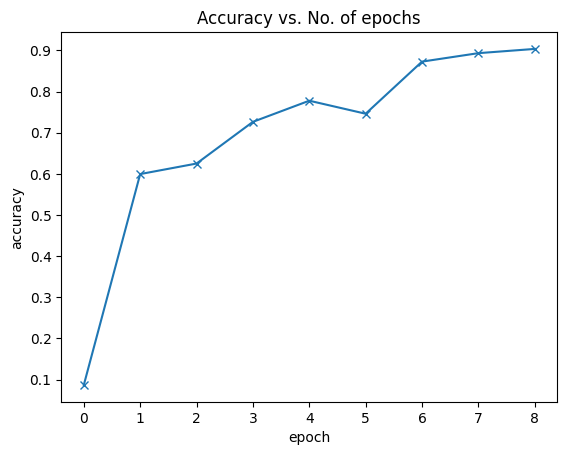

In [22]:
plot_accuracies(history)

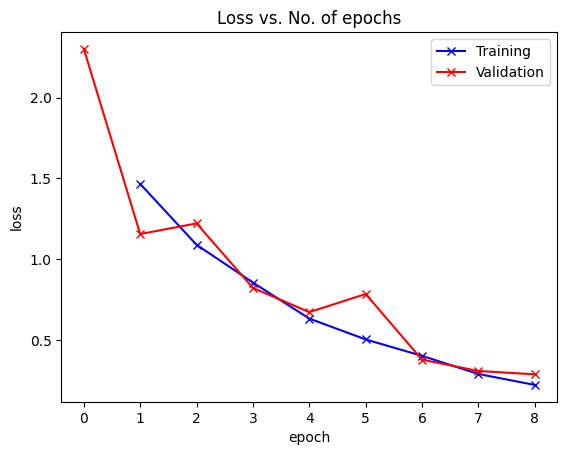

In [23]:
plot_losses(history)

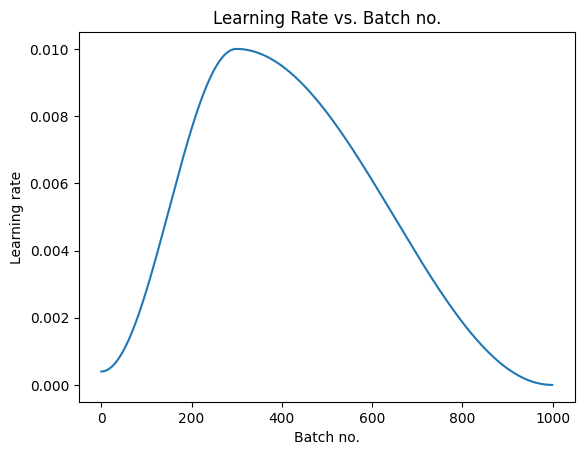

In [24]:
plot_lrs(history)

## Teste

In [25]:
# Testando o modelo
test_dataset = ImageFolder(data_dir + "/test", valid_tfms)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_dl)
result

{'val_loss': 0.2872152328491211, 'val_acc': 0.9035577178001404}